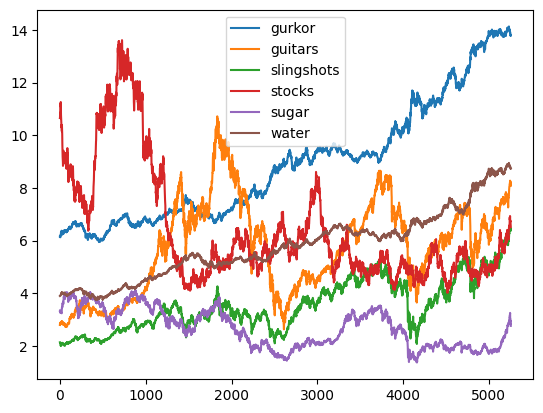

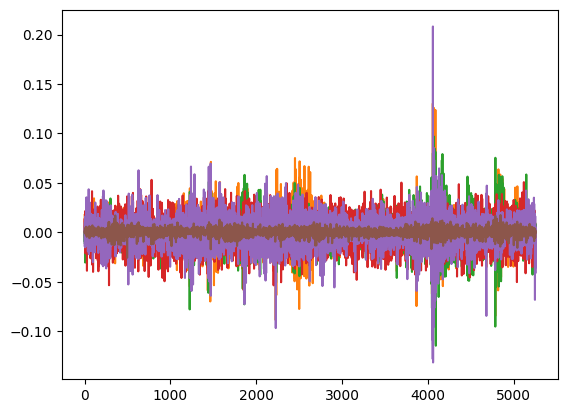

[0.00393213 0.01483519 0.01465271 0.01486665 0.01514651 0.00349728]
[1.61288604e-04 3.12152933e-04 3.17060905e-04 1.69799411e-05
 7.94199178e-05 1.59841947e-04]


In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression

from statsmodels.tsa.stattools import adfuller

from scipy.fft import fft, fftfreq
from scipy.stats import anderson

import seaborn as sns

from arch import arch_model

from scipy.optimize import minimize

import pyomo.environ as pyo

# Load CSV
file_path = "./all_series_stl_imputed.csv"
data = pd.read_csv(file_path)
data = data.drop(columns = ['day', 'tranquillity'])

data.plot()
plt.show()

foo = data.to_numpy().T

bar = []

for i in range(1,foo.shape[1]):
    bar.append((foo[:, i] - foo[:, i-1]) / foo[:, i-1])

bar = np.array(bar)

plt.plot(bar)
plt.show()

ReturnMeans = np.nanmean(bar, axis = 0)

ReturnStd = np.nanstd(bar, axis = 0)

print(ReturnStd)

print(ReturnMeans)




# Portfolio Optimizaiton Notes

Since log returns make all of these TS stationary, we know that the mean, variance, and covariance, are all time-invariant, so then we can just find the covar matrix, and use the mu's to optimize! time to find a solver!

scipy has a built in solver!

Minimizer (same as $-w^T\mu$):
https://docs.scipy.org/doc/scipy/tutorial/optimize.html#sequential-least-squares-programming-slsqp-algorithm-method-slsqp

Stochastic Gradient Descent:






In [179]:
class PortfolioOptimizer:

    def __init__(self, Price, beta = 0.94, columns = ['gurkor', 'guitars', 'slingshots', 'stocks', 'sugar', 'water']):

        #Price
        self.Price = Price[:-200]

        #Log Returns
        self.LogReturns = np.log( self.Price[1:, :] / self.Price[:-1, :])

        #Mean Log Returns
        self.MeanLogReturns = np.nanmean(self.LogReturns, axis = 0)

        #Covariance
        self.cov = np.cov(self.LogReturns.T)

        #Log Rate of Return on Risk Free Asset
        self.rf = np.log(1.03**(1/365))

        #beta
        self.beta = beta

        #asset names
        self.columns = columns



    def __GetCovarianceEstimates(self, Ti, Tf):
        '''
        Returns asset covariance matrix estimate.

        Parameters
        ----------
        beta : float
            forgetting factor in exponential weighted moving average.
        r : numpy.ndarray
            log-returns of each asset over [0,T].
        T : int
            Total number of days to compute covariance estimate.

        This method uses EWMA (exponentially weighted moving average) to estimate the covariance matrix between assets. This involves averaging a number of covariance estimate observations weighted by the forgetting factor, beta. This forgetting factor is raised to the power of the age of the observation.
        
        Returns
        -------
        list
            Retuns a list of numpy.ndarray-s, which are the covariance observations.
        '''

        r = self.LogReturns.T
        beta = self.beta

        CovarianceEstimates = []
        alpha = lambda x : ((1 - beta) / (1 - beta**(x-1))) #normalization factor

        Sigma0 = np.outer(r[:, Ti],r[:, Ti].T) # add first two covariance estimates
        CovarianceEstimates.append(Sigma0)

        Sigma1 = np.outer(r[:, Ti+1],r[:, Ti+1].T)
        CovarianceEstimates.append(Sigma1)

        for t in range(2,Tf - Ti):
            Sigma = np.outer(r[:, Ti],r[:, Ti].T)
            for tau in range(1, t):
                Sigma = Sigma + (  (beta**(t - 1 - tau)) * np.outer(r[:, tau + Ti],r[:, tau + Ti].T)  )

            CovarianceEstimates.append(alpha(t) * Sigma)
                
        return(CovarianceEstimates)
    
    def __MaxSharpeOptimizer(self, S, MeanLogReturns):
        '''
        Finds optimal Max Sharpe Ratio Portfolio.

        Parameters
        ----------
        S : numpy.ndarray
            Covariance matrix
        mu : numpy.ndarray
            :og-returns of each asset.
        rf : float
            Log-return of risk-free asset.

        This method finds the optimal Max Sharpe Ratio Portfolio (MSRP) using the function minimize from scipy's optimization library. The optimization method used is Sequential Least Squares Programming.
        
        Returns
        -------
        numpy.ndarray
            Retuns the optimal MSRP as a numpy.ndarray of the proportion of each asset that make up the portfolio.
        '''

        def NonnegativityConstraint(w):
            return  w
        
        def ProportionConstraint(w):
            return (w.T @ np.ones(w.shape)) - 1
        
        ineq_constraints = {
            "type" : "ineq",
            "fun" : lambda w : np.array(NonnegativityConstraint(w))
        }

        equal_constraints = {
            "type" : "eq",
            "fun" : lambda w : np.array(ProportionConstraint(w))
        }

        def SharpeRatio(w, mu, rf_):
            return ( (w.T @ mu) - rf_ ) / (  np.sqrt(w.T @ S @ w)  )

        results = minimize(
            fun = lambda w : -1 * SharpeRatio(w, MeanLogReturns, self.rf),
            x0 = self.__ApproximateMaxSharpeOptimizer(S, MeanLogReturns, 30),
            method = "SLSQP",
            constraints=[ineq_constraints, equal_constraints]
            )
        
        Portfolio = results['x']

        return Portfolio
    
    def __ApproximateMaxSharpeOptimizer(self, S, MeanLogReturns, n):

        def GeneratePortfolios(n):
            Portfolios = []

            for _ in range(n):

                p = np.random.random(6)
                p = (1/sum(p)) * p
                Portfolios.append(p)

            return Portfolios

        Portfolios = GeneratePortfolios(n)

        ExpectedReturn = []

        Volatility = []

        for w in Portfolios:
            ExpectedReturn.append(w.T @ MeanLogReturns)
            Volatility.append(np.sqrt(w.T @ S @ w))

        ExpectedReturn = np.array(ExpectedReturn)
        Volatility = np.array(Volatility)

        SRs = (ExpectedReturn - self.rf) / Volatility
        StartingPortfolioIndex = np.argmax(SRs)

        PortfolioSR = (Portfolios[StartingPortfolioIndex].T @ MeanLogReturns - self.rf) / np.sqrt(Portfolios[StartingPortfolioIndex].T @ S @ Portfolios[StartingPortfolioIndex])

        #print("Approx SR: ", PortfolioSR)

        return Portfolios[StartingPortfolioIndex]
    
    def __MeanVarianceOptimizer(self, S, MeanLogReturns,  R):

        
        def NonnegativityConstraint(w):
            return  w
        
        def RiskConstraint(w):
            return np.array([ -1 * (w.T @ S @ w) + R])
        
        def ProportionConstraint(w):
            return (w.T @ np.ones(w.shape)) - 1
        
        constraints = [{
            "type" : "ineq",
            "fun" : lambda w : np.concatenate([RiskConstraint(w), NonnegativityConstraint(w)])
        },
        {
            "type" : "eq",
            "fun" : lambda w : ProportionConstraint(w)
        }]

        ObjectiveFunction = lambda w: -1 * (w.T @ MeanLogReturns) #maximize expected return
        
        best_return = -1.0 * np.inf
        best_weights = None

        for _ in range(30):
            x0 = np.random.dirichlet(np.ones(6))  # ensures weights sum to 1 and are >= 0
            result = minimize(ObjectiveFunction, x0, constraints=constraints, method='SLSQP')

            if result.success:
                w = result.x
                port_return = MeanLogReturns.T @ w
                port_risk = w.T @ S @ w

                if port_return > best_return and port_risk <= R:
                    best_return = port_return
                    best_weights = w

        if best_weights is None:
            raise ValueError("No feasible portfolio found under the given risk constraint R.")

        return best_weights
    
    def PlotMVPComposition(self, R, Ti, Tf, TrainFrom):

        Portfolios = []
        Time = []

        CovarianceEstimates = self.__GetCovarianceEstimates(TrainFrom, Tf)

        #Calculate Mean Log Returns
        

        for t in range(Ti, Tf):
            MeanLogReturns = np.nanmean(self.LogReturns[TrainFrom:t-1], axis = 0)

            

            #compute mv portfolio for cov matrix, t
            Porfolio = self.__MeanVarianceOptimizer(CovarianceEstimates[t - TrainFrom - 1], MeanLogReturns, R)

            print(np.round(MeanLogReturns, decimals = 4))
            print(Porfolio)
            print(np.round(Porfolio.T @ MeanLogReturns, decimals = 4))
            print(Porfolio.T @ CovarianceEstimates[t - TrainFrom - 1] @ Porfolio)
            print()
            print()

            #save expected return to an array
            Time.append(t)
            Portfolios.append(Porfolio)

        Portfolios = np.array(Portfolios)

        plt.figure(figsize=(15, 5))
        plt.stackplot(Time, Portfolios.T, baseline='zero', labels = self.columns)

        legend = plt.legend()
        plt.title("Optimal Mean-Variance Portfolio Composition\non $t \in [" + str(Ti) + "," + str(Tf) +"]$ for Risk Level $R =$" + str(R))
        plt.ylabel("Proportion of Portfolio")
        plt.xlabel("Time (days)")

        plt.draw()

        LegendBoundingBox = legend.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted()) 

        xOffset = 0.15
        LegendBoundingBox.x0 += xOffset
        LegendBoundingBox.x1 += xOffset
        legend.set_bbox_to_anchor(LegendBoundingBox, transform = plt.gca().transAxes)
    
    def PlotMSRPComposition(self, Ti, Tf, TrainFrom):
        Portfolios = []
        Time = []

        CovarianceEstimates = self.__GetCovarianceEstimates(TrainFrom, Tf)

        for t in range(Ti, Tf):

            #calculate mean log returns
            MeanLogReturns = np.nanmean(self.LogReturns[TrainFrom:t-1], axis = 0)

            #compute mv portfolio for cov matrix, t
            Porfolio = self.__MaxSharpeOptimizer(CovarianceEstimates[t - TrainFrom - 1], MeanLogReturns)

            #save expected return to an array
            Time.append(t)
            Portfolios.append(Porfolio)


        Portfolios = np.array(Portfolios)

        plt.figure(figsize=(15, 5))
        plt.stackplot(Time, Portfolios.T, baseline='zero', labels = self.columns)

        legend = plt.legend()
        plt.title("Max Sharpe Ratio Portfolio Composition\non $t \in [" + str(Ti) + "," + str(Tf) +"]$")
        plt.ylabel("Proportion of Portfolio")
        plt.xlabel("Time (days)")

        plt.draw()

        LegendBoundingBox = legend.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted()) 

        xOffset = 0.15
        LegendBoundingBox.x0 += xOffset
        LegendBoundingBox.x1 += xOffset
        legend.set_bbox_to_anchor(LegendBoundingBox, transform = plt.gca().transAxes)
    
    
    def GetMSRPSBackTest(self, InitialWealth, RebalancingPeriod, Ti, Tf, TrainFrom):

        GetWealth = lambda Price, Portfolio, Cash : (Portfolio.T @ Price) + Cash

        CovarianceEstimates = self.__GetCovarianceEstimates(TrainFrom, Tf)
        
        Wealth = np.zeros(Tf - Ti)
        Wealth[0] = InitialWealth

        Cash = np.zeros(Tf - Ti)
        
        ReblanceEvents = RebalancingPeriod * np.arange((Tf - Ti // RebalancingPeriod))

        Portfolios = []

        #Initial Portfolio
        InitialMeanLogReturns = np.nanmean(self.LogReturns[TrainFrom:Ti-1,:], axis = 0)
        StartingOptimalProportions = np.round(self.__MaxSharpeOptimizer(CovarianceEstimates[Ti - TrainFrom - 1], InitialMeanLogReturns), decimals = 10)
        n  = Wealth[0] / (StartingOptimalProportions.T @ self.Price[Ti-1, :])
        CurrentPortfolio = np.floor(n*StartingOptimalProportions)

        Cash[0] = Wealth[0] - (CurrentPortfolio.T @ self.Price[Ti-1, :])

        for t in range(Ti+1, Tf):

            #Find Average Returns 
            if((t - Ti) % RebalancingPeriod == 0):

                MeanLogReturns = np.nanmean(self.LogReturns[TrainFrom:t-1, :], axis = 0)

                #Rebalancing
                OptimalProportions = np.round(self.__MaxSharpeOptimizer(CovarianceEstimates[t-TrainFrom-1], MeanLogReturns), decimals = 10) #SampleLogReturns[t-1] because using SampleLogReturns[t] would tell us about a future we don't know
                
                n  = Wealth[t-Ti - 1] / (OptimalProportions.T @ self.Price[t, :])

                CurrentPortfolio = np.floor(n*OptimalProportions)

                Cash[t - Ti] = Wealth[t-Ti - 1] - (CurrentPortfolio.T @ self.Price[t, :])

            else:
                Cash[t - Ti] = Cash[t - Ti - 1]



            #Calculate Portfolio Value
            Wealth[t - Ti] = CurrentPortfolio.T @ self.Price[t, :] + Cash[t - Ti]

            Portfolios.append(CurrentPortfolio)

        return(Wealth)
    
    def GetApproximateMSRPSBackTest(self, InitialWealth, RebalancingPeriod, n, Ti, Tf):
        GetWealth = lambda Price, Portfolio, Cash : (Portfolio.T @ Price) + Cash

        CovarianceEstimates = self.__GetCovarianceEstimates(Ti, Tf)
        
        Wealth = np.zeros(Tf - Ti)
        Wealth[0] = InitialWealth

        Cash = np.zeros(Tf - Ti)
        
        ReblanceEvents = RebalancingPeriod * np.arange((Tf - Ti // RebalancingPeriod))

        Portfolios = []

        #Initial Portfolio
        InitialMeanLogReturns = np.nanmean(self.LogReturns[:Ti-1,:], axis = 0)
        StartingOptimalProportions = np.round(self.__ApproximateMaxSharpeOptimizer(CovarianceEstimates[0], InitialMeanLogReturns, n), decimals = 10)
        k  = Wealth[0] / (StartingOptimalProportions.T @ self.Price[Ti-1, :])
        CurrentPortfolio = np.floor(k*StartingOptimalProportions)

        Cash[0] = Wealth[0] - (CurrentPortfolio.T @ self.Price[Ti-1, :])

        for t in range(Ti+1, Tf):

            #Find Average Returns 
            if((t - Ti) % RebalancingPeriod == 0):

                MeanLogReturns = np.nanmean(self.LogReturns[:t-1, :], axis = 0)

                #Rebalancing
                OptimalProportions = np.round(self.__ApproximateMaxSharpeOptimizer(CovarianceEstimates[t-Ti-1], MeanLogReturns, n), decimals = 10) #SampleLogReturns[t-1] because using SampleLogReturns[t] would tell us about a future we don't know
                
                k  = Wealth[t-Ti - 1] / (OptimalProportions.T @ self.Price[t, :])

                CurrentPortfolio = np.floor(k*OptimalProportions)

                Cash[t - Ti] = Wealth[t-Ti - 1] - (CurrentPortfolio.T @ self.Price[t, :])

            else:
                Cash[t - Ti] = Cash[t - Ti - 1]



            #Calculate Portfolio Value
            Wealth[t - Ti] = CurrentPortfolio.T @ self.Price[t, :] + Cash[t - Ti]

            Portfolios.append(CurrentPortfolio)

        return(Wealth)
    
    def GetMVPBackTest(self, InitialWealth, RebalancingPeriod, R, Ti, Tf, TrainFrom):
        GetWealth = lambda Price, Portfolio, Cash : (Portfolio.T @ Price) + Cash

        CovarianceEstimates = self.__GetCovarianceEstimates(TrainFrom, Tf)
        
        Wealth = np.zeros(Tf - Ti)
        Wealth[0] = InitialWealth

        Cash = np.zeros(Tf - Ti)
        
        ReblanceEvents = RebalancingPeriod * np.arange((Tf - Ti // RebalancingPeriod))

        Portfolios = []

        #Initial Portfolio
        InitialMeanLogReturns = np.nanmean(self.LogReturns[TrainFrom:Ti-1,:], axis = 0)
        StartingOptimalProportions = np.round(self.__MeanVarianceOptimizer(CovarianceEstimates[Ti - TrainFrom - 1], InitialMeanLogReturns, R), decimals = 10)
        k  = Wealth[0] / (StartingOptimalProportions.T @ self.Price[Ti-1, :])
        CurrentPortfolio = np.floor(k*StartingOptimalProportions)

        Cash[0] = Wealth[0] - (CurrentPortfolio.T @ self.Price[Ti-1, :])

        for t in range(Ti+1, Tf):

            #Find Average Returns 
            if((t - Ti) % RebalancingPeriod == 0):

                MeanLogReturns = np.nanmean(self.LogReturns[TrainFrom:t-1, :], axis = 0)

                #Rebalancing
                OptimalProportions = np.round(self.__MeanVarianceOptimizer(CovarianceEstimates[t-TrainFrom-1], MeanLogReturns, R), decimals = 10) #SampleLogReturns[t-1] because using SampleLogReturns[t] would tell us about a future we don't know

                k  = Wealth[t-Ti - 1] / (OptimalProportions.T @ self.Price[t, :])

                CurrentPortfolio = np.floor(k*OptimalProportions)

                Cash[t - Ti] = Wealth[t-Ti - 1] - (CurrentPortfolio.T @ self.Price[t, :])

            else:
                Cash[t - Ti] = Cash[t - Ti - 1]



            #Calculate Portfolio Value
            Wealth[t - Ti] = CurrentPortfolio.T @ self.Price[t, :] + Cash[t - Ti]

            Portfolios.append(CurrentPortfolio)

        return(Wealth)

[ 0.0005  0.0002 -0.0003 -0.0026  0.0011  0.0001]
[ 3.97949398e-17 -3.89419103e-17 -8.16643534e-17 -2.55399248e-17
  1.00000000e+00 -2.77555756e-17]
0.0011
0.00015380153894273423


[ 0.0005  0.0002 -0.0002 -0.0026  0.0012  0.0002]
[ 0.00000000e+00 -3.57510870e-17  7.92702101e-17 -1.86623596e-16
  1.00000000e+00 -9.24234392e-18]
0.0012
0.00015308659240993798


[ 0.0005  0.0002 -0.0002 -0.0024  0.0012  0.0001]
[-2.97388647e-16 -5.68989300e-16  1.52555864e-17 -2.39750297e-16
  1.00000000e+00  1.50839723e-16]
0.0012
0.00014457513435065298


[ 0.0005  0.0003 -0.0001 -0.0022  0.0013  0.0002]
[-4.59463111e-17  2.77555756e-17  3.14310047e-16 -4.25619961e-16
  1.00000000e+00 -1.91481605e-16]
0.0013
0.00014729722419345865


[ 0.0005  0.0002 -0.0001 -0.002   0.0012  0.0002]
[ 4.21660415e-17 -4.16333634e-16 -4.45968251e-17 -8.78611822e-17
  1.00000000e+00  5.01828449e-17]
0.0012
0.00014826155530892084


[ 0.0005  0.0002 -0.     -0.002   0.0012  0.0002]
[-2.22044605e-16  4.35655628e-16 -1.63962067e

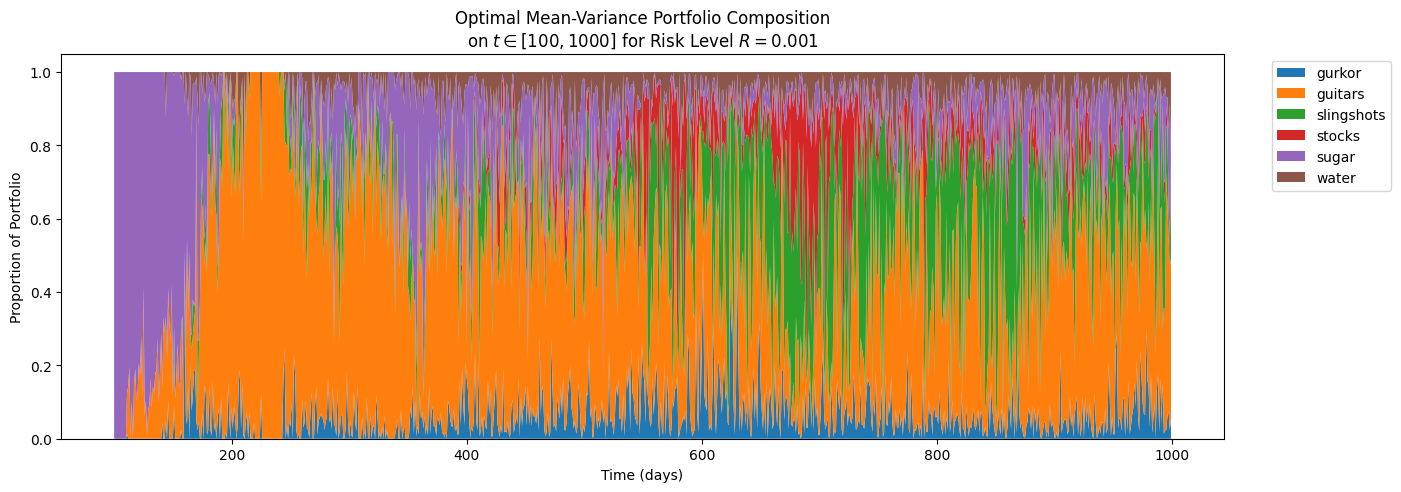

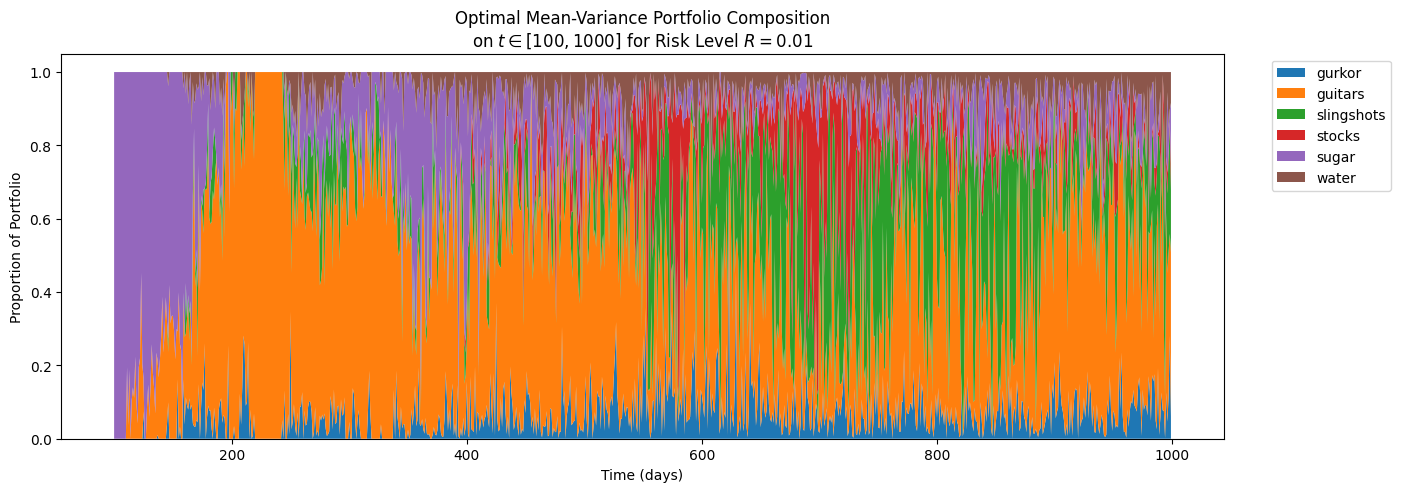

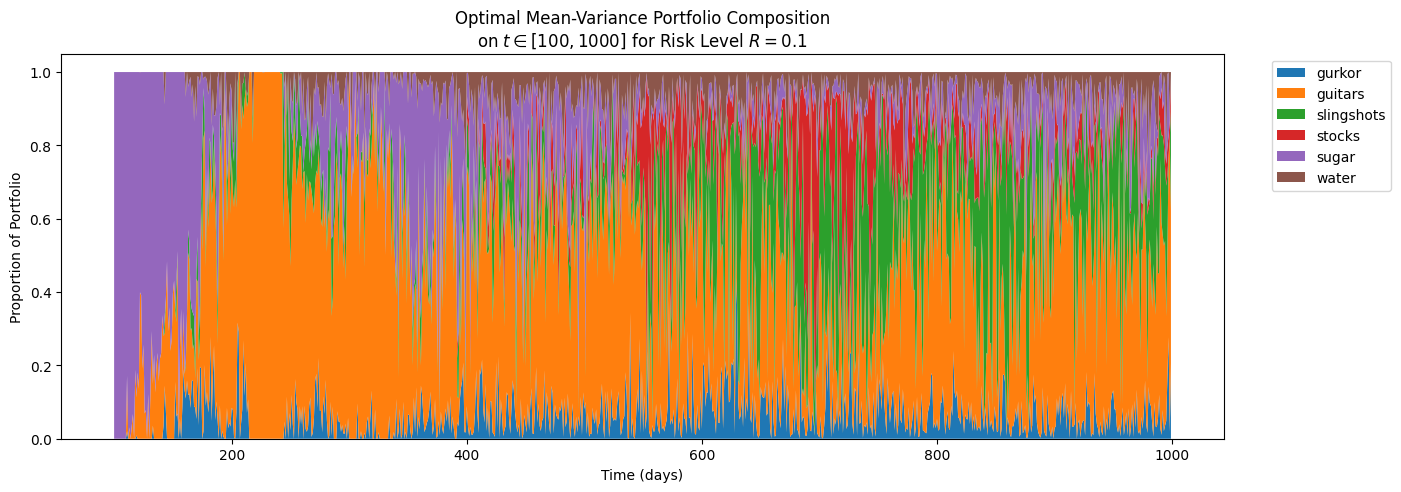

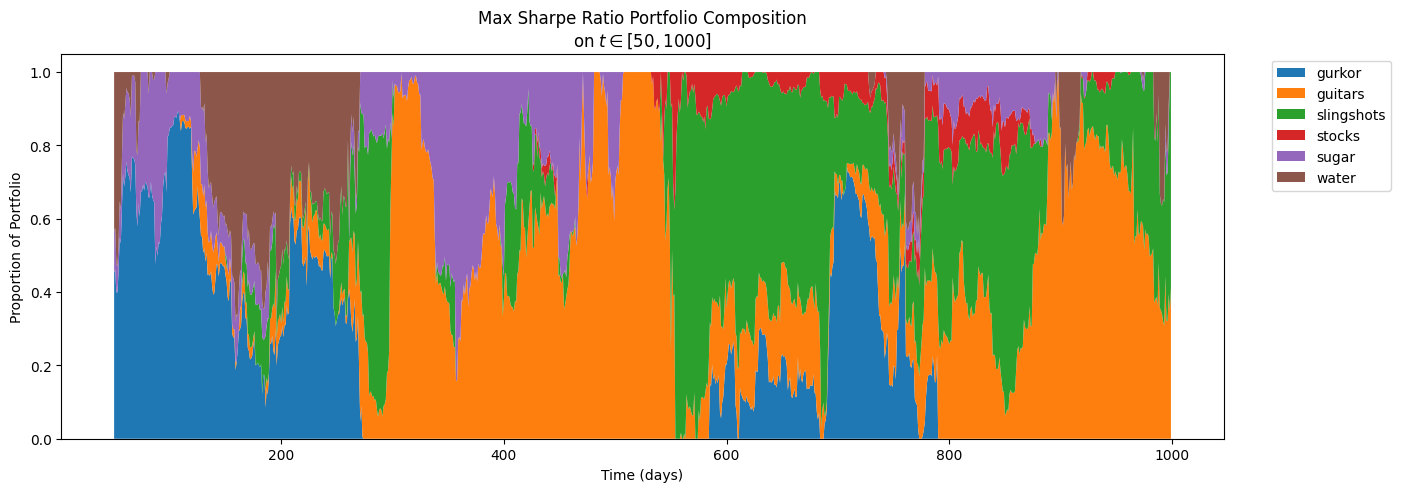

In [180]:
po = PortfolioOptimizer(data.to_numpy())

po.PlotMVPComposition(1e-3, 100, 1000, 0)
po.PlotMVPComposition(1e-2, 100, 1000, 0)
po.PlotMVPComposition(1e-1, 100, 1000, 0)
po.PlotMSRPComposition(50, 1000, 1)

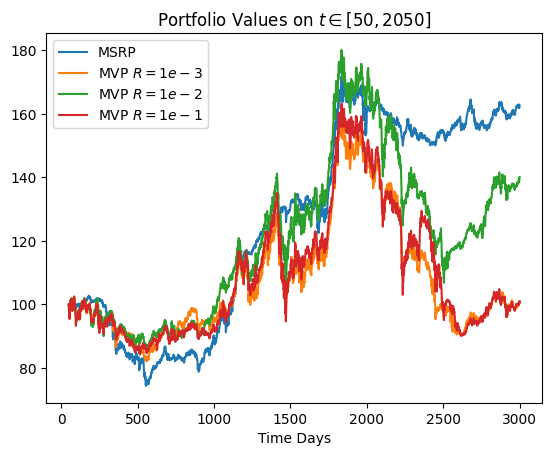

In [181]:
po = PortfolioOptimizer(data.to_numpy())

MSRPValue = po.GetMSRPSBackTest(100, 30, 50, 3000, 0)
MVPValue0 = po.GetMVPBackTest(100, 30, 1e-3, 50, 3000, 0)
MVPValue1 = po.GetMVPBackTest(100, 30, 1e-2, 50, 3000, 0)
MVPValue2 = po.GetMVPBackTest(100, 30, 1e-1, 50, 3000, 0)
Time = np.arange(50, 3000, 1)

plt.plot(Time, MSRPValue, label = "MSRP")
plt.plot(Time, MVPValue0, label = "MVP $R=1e-3$")
plt.plot(Time, MVPValue1, label = "MVP $R=1e-2$")
plt.plot(Time, MVPValue2, label = "MVP $R=1e-1$")
plt.title("Portfolio Values on $t \in [50, 2050]$")
plt.xlabel("Time Days")
plt.legend()
plt.show()

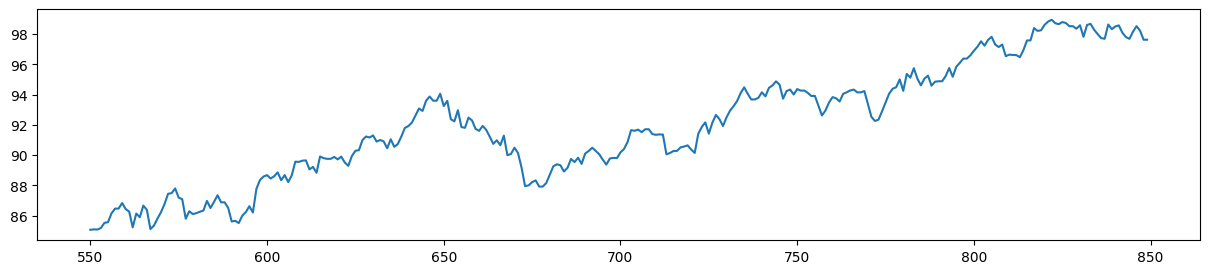

In [182]:
plt.plot(Time[500:800], MVPValue0[532:832])
plt.gcf().set_size_inches(15, 3)
plt.show()

In [183]:
po = PortfolioOptimizer(data.to_numpy())

# [0, :, :] is sharpe ratio
# [1, :, :] is Period Return
# [2, :, :] is Log Return Volatility
# Shape is (3, 6, k) for 3 statistics, 6 assets, k-fold cross-validation
# statistic 0 is SR, statistic 1 is Period Return, statistic 2 is Log Return Volatility

def GetLogReturns(w):
    log_w = np.log(w[1:] / w[:-1])
    return(log_w)

def GetSR(w, rf = np.log(1.03**(1/365))):
    return( (np.nanmean(GetLogReturns(w)) - rf) / np.nanstd(GetLogReturns(w)) )

def GetReturn(w):
    return ((w[-1] - w[0]) / w[0])

def GetVolatility(w):
    log_w = GetLogReturns(w)
    return np.nanstd(log_w)

k = 50
Shifts = list(np.random.randint(1, 1650, k))
DataTensor = np.zeros((3,4,k))

Ti = 50
Tf = 350
step = 1

BackTests = [
    lambda k : po.GetMSRPSBackTest(100, 30, Ti+k, Tf+k, 0 + k),
    lambda k : po.GetMVPBackTest(100, 30, 1e-3, Ti+k, Tf+k, 0 + k),
    lambda k : po.GetMVPBackTest(100, 30, 1e-2, Ti+k, Tf+k, 0 + k),
    lambda k : po.GetMVPBackTest(100, 30, 1e-1, Ti+k, Tf+k, 0 + k)
]

for i, shift in enumerate(Shifts):
    print(i)
    for AssetIndex, BackTest  in enumerate(BackTests):
        for StatIndex, GetStat  in enumerate([GetSR, GetReturn, GetVolatility]):
            DataTensor[StatIndex, AssetIndex, i] = GetStat(BackTest(shift))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Asset Mean:  0.029283237562423542
Asset Mean:  0.019692002421597153
Asset Mean:  0.020395689228817647
Asset Mean:  0.020557059847029168


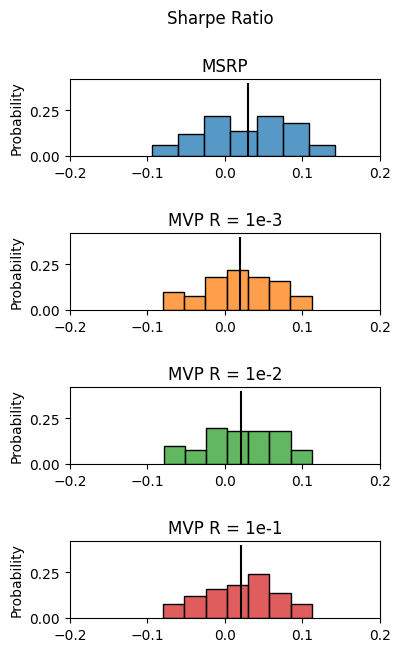

Asset Mean:  0.09348858604273257
Asset Mean:  0.12603492566357552
Asset Mean:  0.13207752159862562
Asset Mean:  0.1385525388353236


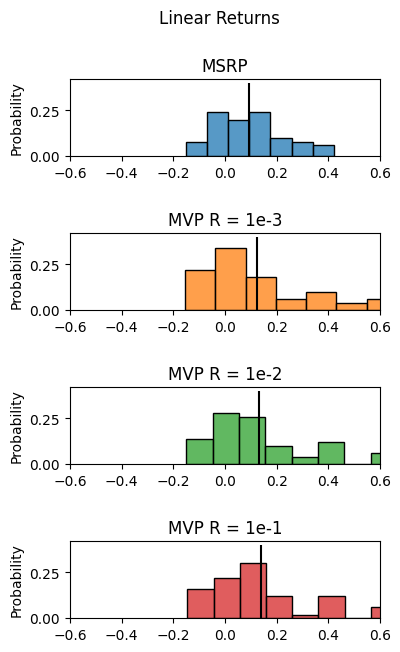

Asset Mean:  0.00664033013151083
Asset Mean:  0.010452347011450097
Asset Mean:  0.010487967750917567
Asset Mean:  0.01039709507429623


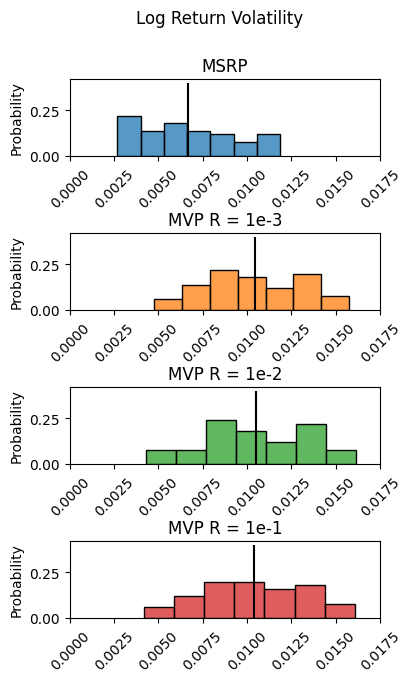

In [187]:
Statistics = ["Sharpe Ratio", "Linear Returns", "Log Return Volatility"]
Assets = ["MSRP", "MVP R = 1e-3", "MVP R = 1e-2", "MVP R = 1e-1"]



fig, axs = plt.subplots(len(Assets),1, figsize=(4, 7))
plt.subplots_adjust(hspace = 1)
for AssetIndex, Asset in enumerate(Assets):
        sns.histplot(DataTensor[0, AssetIndex, :], label = Asset, stat = "probability", ax = axs[AssetIndex], color = "C" + str(AssetIndex)) # SR for MSRP
        print("Asset Mean: ", np.nanmean(DataTensor[0, AssetIndex, :]))
        axs[AssetIndex].vlines(np.nanmean(DataTensor[0, AssetIndex, :]), 0,0.4, color = "black")
        axs[AssetIndex].set_xlim([-0.2, 0.2])
        axs[AssetIndex].set_title(Asset)
plt.suptitle(Statistics[0])
plt.show()

fig, axs = plt.subplots(len(Assets),1, figsize=(4, 7))
plt.subplots_adjust(hspace = 1)
for AssetIndex, Asset in enumerate(Assets):
        sns.histplot(DataTensor[1, AssetIndex, :], label = Asset, stat = "probability", ax = axs[AssetIndex], color = "C" + str(AssetIndex)) # SR for MSRP
        print("Asset Mean: ", np.nanmean(DataTensor[1, AssetIndex, :]))
        axs[AssetIndex].vlines(np.nanmean(DataTensor[1, AssetIndex, :]), 0, 0.4, color = "black")
        axs[AssetIndex].set_xlim([-0.6, 0.6])
        axs[AssetIndex].set_title(Asset)
plt.suptitle(Statistics[1])
plt.show()

fig, axs = plt.subplots(len(Assets),1, figsize=(4, 7))
plt.subplots_adjust(hspace = 1)
for AssetIndex, Asset in enumerate(Assets):
        sns.histplot(DataTensor[2, AssetIndex, :], label = Asset, stat = "probability", ax = axs[AssetIndex], color = "C" + str(AssetIndex)) # SR for MSRP
        print("Asset Mean: ", np.nanmean(DataTensor[2, AssetIndex, :]))
        axs[AssetIndex].vlines(np.nanmean(DataTensor[2, AssetIndex, :]), 0,0.4, color = "black")
        axs[AssetIndex].set_xlim([0, 0.0175])
        axs[AssetIndex].set_title(Asset)
        
        for tick in axs[AssetIndex].get_xticklabels():
                tick.set_rotation(45)
plt.suptitle(Statistics[2])
plt.show()

# Portfolio Backtesting Notes

### Look Ahead Bias
This is data leakage, and can come about a couple of ways. For instance, computing a portfolio value as $w_t^T r_t^{\text{lin}}$ would be incorrect and give future information about the stock. What really needs to be done in that case is $R_t^{\text{portf}} = w_{t-1}^T r_t^{\text{lin}}$. This is because returns tell you how much the asset increased from $t-1$ to $t$.

In [185]:
np.cov(data.to_numpy()[:-200, :].T).shape

(6, 6)

In [186]:
x = np.array([1,2,3])
y = np.array([5,3,2])
type(x.T @ y)

numpy.int64